In [26]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from skimage import io, draw
import numpy as np


In [19]:
def show(title,image):
    ii=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  
    io.imshow(ii)
    print(f"{title} : ")
    io.show()

In [145]:
model = keras.models.load_model("./models/deeplabv3_plus_res2netSE.h5")

In [163]:

def mask_eye(im_base,img):       #捕捉眼睛
    eye_kernel = np.ones((3,15), np.uint8)
    temp = cv2.dilate(im_base, eye_kernel, iterations =2 )
    eye = img[0].copy()
    eye[temp==0]=[0,0,0]
    gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)

    (cnts, _) = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in cnts:
        clone = eye.copy()
        (x, y, w, h) = cv2.boundingRect(c)
        cx = x+w//2
        cy = y+h//2
       
        clone = clone[y:y+h,x:x+w]

        clone=cv2.resize(clone,dsize=None,fx=1,fy=1)
        new_h,new_w=clone.shape[0:2]
        new_x = cx-new_w//2
        new_y = cy-new_h//2
        eye[new_y:new_y+new_h,new_x:new_x+new_w] = clone
    return eye

def mask_face(im_base,img):    #捕捉全臉
    kernel = np.ones((5,5), np.uint8)
    temp = cv2.dilate(im_base, kernel, iterations =2 )
    face = img[0].copy()
    face[temp!=1]=[0,0,0]
    
    return face

def mask_mount(im_base,img):   #捕捉嘴巴
    mount_kernel = np.ones((5,5), np.uint8)
    temp = cv2.dilate(im_base, mount_kernel, iterations =1 )
    mount = img[0].copy()
    mount[temp==0]=[0,0,0]
    gray = cv2.cvtColor(mount, cv2.COLOR_BGR2GRAY)

    (cnts, _) = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    for c in cnts:
        clone = mount.copy()
        (x, y, w, h) = cv2.boundingRect(c)
        cx = x+w//2
        cy = y+h//2
        clone = clone[y:y+h,x:x+w]
        clone=cv2.resize(clone,dsize=None,fx=1.0,fy=1.0)
        new_h,new_w=clone.shape[0:2]
        new_x = cx-new_w//2
        new_y = cy-new_h//2
        mount[new_y:new_y+new_h,new_x:new_x+new_w] = clone
    
    return mount

In [169]:
def get_maskimg(model,crop_img,image_size,debug=False):
    img = cv2.resize(crop_img,image_size)
    img = np.reshape(img,(1,)+image_size+(3,))
    ans=model.predict(img/255.0)[0]
    im_base = np.zeros((4,image_size[0],image_size[1]))

    for j in range(1,4):
        x = ans[:,:,j]      
        if j>1: im_base[j-1,x>0.3]=1
        im_base[3,x>0.5]=1
        

    eye = mask_eye(im_base[1],img)
    if debug: show('eye',eye)
        
    mount = mask_mount(im_base[2],img)
    if debug: show('mount',mount)
        
    face = mask_face(im_base[3],img)
    if debug: show('face',face)

   
    
#     add_img = cv2.add(eye,mount)
#     gray_add_img = cv2.cvtColor(add_img, cv2.COLOR_BGR2GRAY)  
    
#     mask = (add_img!=[0,0,0])[:,:,0]
#     face[mask] = add_img[mask]
#     #plt.imshow(face)
#     return face

    return {'eye':eye,'mount':mount,'face':face}

原圖人臉偵測結果 : 


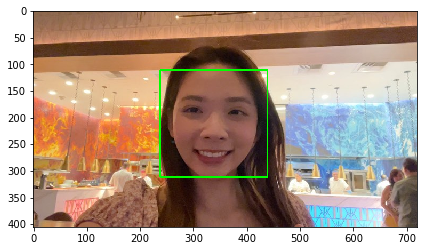

crop_img : 


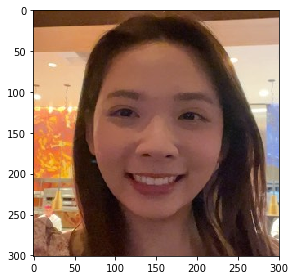

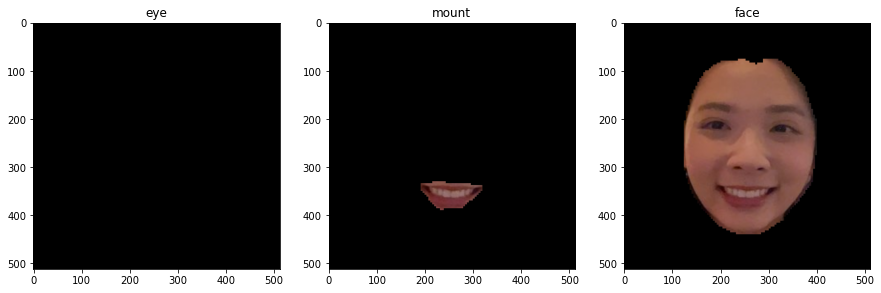

In [178]:
img_path = './inputs/DM.jpg'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   

face_cascade = cv2.CascadeClassifier("./models/haarcascade_frontalface_default.xml")   # 載入人臉模型
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=9)    # 偵測人臉
face_img = []

for (x, y, w, h) in faces:
    c_img = img.copy()
    cv2.rectangle(c_img, (x, y), (x+w, y+h), (0, 255, 0), 2)    # 利用 for 迴圈，抓取每個人臉屬性，繪製方框
    temp = img[max(0,y-50):min(y+h+50,c_img.shape[0]), max(x-50,0):min(x+w+50,c_img.shape[1]),:] #將原始人臉方框增大範圍

    face_img.append(temp)
    
show('原圖人臉偵測結果',c_img)
for crop_img in face_img:
    show('crop_img',crop_img)  #要送入model 預測的圖片
    
    mask_img=get_maskimg(model,crop_img,(512,512),debug=False) 

    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1).set_title('eye')
    a = cv2.cvtColor(mask_img['eye'], cv2.COLOR_BGR2RGB)   
    plt.imshow(a)
    
    plt.subplot(1,3,2).set_title('mount')
    a = cv2.cvtColor(mask_img['mount'], cv2.COLOR_BGR2RGB)   
    plt.imshow(a)
    
    plt.subplot(1,3,3).set_title('face')
    a = cv2.cvtColor(mask_img['face'], cv2.COLOR_BGR2RGB)   
    plt.imshow(a)
    
    plt.show()
        

In [166]:
print()